# LSTM tests

In [1]:
import matplotlib 
import matplotlib.pyplot as plt 
import pandas_datareader as dt
import io, base64, os, json, re , math
import pandas as pd 
import numpy as np
import datetime
import warnings
import calendar
import statsmodels.api as sm
import datetime
from dateutil import relativedelta

import calendar, os, io, base64
from dateutil import relativedelta



%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
#load the cli data
cci_raw=pd.read_csv('https://stats.oecd.org/sdmx-json/data/DP_LIVE/OECD.BCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en')
cci_df=cci_raw[cci_raw['LOCATION'] =='OECD']
    
full_date_list=[]
for tm in cci_df['TIME']:
    year=int(tm.split('-')[0])
    month=int(tm.split('-')[1])
    #print calendar full date
    full_date_list.append(tm + '-'+str(calendar.monthrange(year,month)[1]))
        
cci_df['Date'] = full_date_list
cci_df['Date']= pd.to_datetime(cci_df['Date'])
cci_df=cci_df[['Date','Value']]
cci_df.index=cci_df['Date']


In [3]:
cci_df_full=cci_df[['Date','Value']]
cci_df_full = cci_df_full.set_index('Date')
cci_df_full

,Value
Date,
1974-06-30,100.4889
1974-07-31,100.0770
1974-08-31,99.5129
1974-09-30,98.7777
1974-10-31,98.0333
...,...
2019-12-31,99.5346
2020-01-31,99.5861
2020-02-29,99.3355


In [6]:
prediction_months=12

#Make a prediction column by shifting the values up by 12 months
cci_df['Prediction']=cci_df[['Value']].shift(-prediction_months)

#make several rollingMA to help the model learn better
cci_df['7_months MA']=cci_df['Value'].rolling(window=7).mean()
cci_df['4_months MA']=cci_df['Value'].rolling(window=4).mean()
cci_df['2_months MA']=cci_df['Value'].rolling(window=2).mean()



#drop the NaN values
cci_cleaned=cci_df.dropna(subset=['7_months MA','4_months MA','2_months MA', 'Prediction'])

#cci_cleaned2=cci_svm.dropna(subset=['Prediction'])

#Get rid of the NAN values
cci_cleaned.reset_index(drop=True, inplace=True)

del cci_cleaned['Date']


cci_cleaned.tail(20)



,Value,Prediction,7_months MA,4_months MA,2_months MA
513,101.3097,100.9765,100.967429,101.119625,101.24835
514,101.3449,100.8356,101.055343,101.222300,101.32730
515,101.3549,100.7123,101.141243,101.299125,101.34990
516,101.3662,100.5417,101.220643,101.343925,101.36055
517,101.3524,100.4082,101.280386,101.354600,101.35930
518,101.3114,100.2903,101.318071,101.346225,101.33190
519,101.2179,100.2066,101.322486,101.311975,101.26465
520,101.1447,100.0907,101.298914,101.256600,101.18130
521,101.1372,99.9579,101.269243,101.202800,101.14095
522,101.1430,99.8045,101.238971,101.160700,101.14010


In [26]:
future_x_inputs=cci_cleaned.copy()

#drop the 'Prediction' column as that is the y label
del future_x_inputs['Prediction']

#Normalize the future x inputs and put in array
future_x_inputs=np.log(future_x_inputs)
future_x_inputs=future_x_inputs.to_numpy()

#Bare in mind this does not include the very last 12 months x_feature values 
# of the cci but the 12 values before it

#We are only interested in the last 12 month values from the cleaned data
future_x_inputs=future_x_inputs[-12:]
#future_x_inputs=np.delete(future_x_inputs,1)
future_x_inputs


array([[4.61647801, 4.61778274, 4.61712642, 4.61651509],
       [4.61653536, 4.61748378, 4.61671034, 4.61650668],
       [4.61633958, 4.61714082, 4.61647628, 4.61643747],
       [4.6159934 , 4.61676782, 4.61633661, 4.6161665 ],
       [4.61488782, 4.61629479, 4.61593924, 4.61544076],
       [4.61349147, 4.61575454, 4.61517868, 4.61418989],
       [4.61226794, 4.61514315, 4.61416115, 4.61287989],
       [4.61057257, 4.61430052, 4.61280621, 4.61142061],
       [4.60924388, 4.61325981, 4.61139527, 4.60990844],
       [4.60806898, 4.61207884, 4.61003956, 4.6086566 ],
       [4.60723405, 4.6108273 , 4.60878066, 4.6076516 ],
       [4.60607677, 4.60956821, 4.60765659, 4.60665558]])

In [10]:
#Get the all the neccessary column values
values=cci_cleaned[['Value','7_months MA','4_months MA','2_months MA','Prediction']]

#change values to log form
values=np.log(values)

#change format to numpy array
values=values.to_numpy()
values

array([[4.57258294, 4.59225341, 4.5822536 , 4.57536334, 4.60357391],
       [4.57038928, 4.58658308, 4.57662049, 4.57148671, 4.60641841],
       [4.57065224, 4.58152029, 4.57294499, 4.57052077, 4.60873483],
       ...,
       [4.60806898, 4.61207884, 4.61003956, 4.6086566 , 4.59850301],
       [4.60723405, 4.6108273 , 4.60878066, 4.6076516 , 4.59051736],
       [4.60607677, 4.60956821, 4.60765659, 4.60665558, 4.57618309]])

In [11]:
X=values[:,0:4]


X

array([[4.57258294, 4.59225341, 4.5822536 , 4.57536334],
       [4.57038928, 4.58658308, 4.57662049, 4.57148671],
       [4.57065224, 4.58152029, 4.57294499, 4.57052077],
       ...,
       [4.60806898, 4.61207884, 4.61003956, 4.6086566 ],
       [4.60723405, 4.6108273 , 4.60878066, 4.6076516 ],
       [4.60607677, 4.60956821, 4.60765659, 4.60665558]])

In [12]:
y=values[:,4:5]
y


array([[4.60357391],
       [4.60641841],
       [4.60873483],
       [4.60986813],
       [4.61073269],
       [4.61071081],
       [4.61007414],
       [4.60878365],
       [4.60729792],
       [4.60597486],
       [4.60502518],
       [4.60452498],
       [4.60491215],
       [4.60489315],
       [4.60507718],
       [4.60485914],
       [4.60433284],
       [4.60367807],
       [4.60242241],
       [4.60126457],
       [4.60003402],
       [4.59947198],
       [4.59994556],
       [4.60101055],
       [4.60207139],
       [4.60205233],
       [4.60196405],
       [4.60267307],
       [4.60458802],
       [4.60691367],
       [4.60895402],
       [4.61055765],
       [4.61141763],
       [4.61203159],
       [4.61254096],
       [4.61279306],
       [4.61244367],
       [4.61221134],
       [4.61228879],
       [4.61260746],
       [4.612669  ],
       [4.61213885],
       [4.61091366],
       [4.60925682],
       [4.60772691],
       [4.60668604],
       [4.60561609],
       [4.604

In [13]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [14]:
#import the neccessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [15]:
#splt the data to 80 learning 20 test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

In [16]:
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))



In [17]:
model_lstm =Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))

In [18]:
model_lstm.compile(optimizer='adam',loss='mean_squared_error')
monitor=EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=0)
history=model_lstm.fit(X_train,y_train,validation_data=(X_test,y_test), callbacks=[monitor],epochs=250)

Train on 357 samples, validate on 176 samples
Epoch 1/250
357/357 [==============================] - 9s 24ms/sample - loss: 17.0069 - val_loss: 8.1973
Epoch 2/250
357/357 [==============================] - 0s 286us/sample - loss: 2.8989 - val_loss: 0.7751
Epoch 3/250
357/357 [==============================] - 0s 283us/sample - loss: 0.7869 - val_loss: 6.5954e-04
Epoch 4/250
357/357 [==============================] - 0s 286us/sample - loss: 0.1472 - val_loss: 0.1148
Epoch 5/250
357/357 [==============================] - 0s 347us/sample - loss: 0.0326 - val_loss: 0.0414
Epoch 6/250
357/357 [==============================] - 0s 331us/sample - loss: 0.0183 - val_loss: 0.0036
Epoch 7/250
357/357 [==============================] - 0s 317us/sample - loss: 0.0056 - val_loss: 1.3185e-04
Epoch 8/250
357/357 [==============================] - 0s 328us/sample - loss: 0.0011 - val_loss: 5.3752e-04
Epoch 9/250
357/357 [==============================] - 0s 322us/sample - loss: 2.9278e-04 - val_loss: 

In [19]:
print(history.history['loss'])

print(history.history['val_loss'])


[17.006889466144123, 2.898868903992515, 0.7868725521416933, 0.14719260600852033, 0.032552488659526785, 0.018334907015553396, 0.005585291426001424, 0.0011185766849927709, 0.0002927768131566732, 0.00015358621090518003, 0.00012365290447133686, 9.114042525955786e-05, 8.565280077469774e-05, 8.253120577952685e-05, 8.165464793669101e-05, 8.203657977623768e-05, 8.148623199798218e-05, 8.192559802797196e-05, 8.193841445152465e-05, 8.263898240477342e-05, 8.18580760891518e-05, 8.281521848973581e-05, 8.298040294536476e-05, 8.402645575448073e-05, 8.241179164731223e-05, 8.166135274182291e-05, 8.164604383148057e-05, 8.625901896533939e-05, 8.329620478824446e-05, 8.084944083977553e-05, 8.34462536725213e-05, 8.258513238009375e-05, 8.44590303684384e-05, 8.174877872252615e-05, 8.223038665684206e-05, 8.162739857866922e-05, 8.302021570143705e-05, 8.741813204420799e-05, 8.261969505379783e-05, 8.931031880420254e-05, 8.311302062232929e-05, 8.153103210709608e-05, 8.158163889405005e-05, 8.234247859497376e-05, 8.2

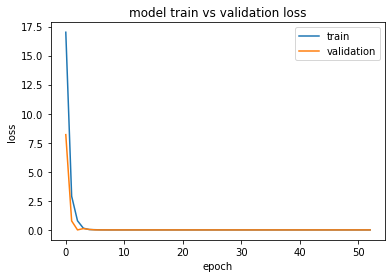

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [21]:
X_train=X_train[:,:,0]
X_train.shape

(357, 4)

In [22]:
y_test2=np.exp(y_test)
y_test2

array([[100.4916],
       [100.0477],
       [100.0861],
       [100.0357],
       [ 99.6349],
       [100.2218],
       [ 99.6766],
       [ 99.994 ],
       [100.6264],
       [ 97.9537],
       [100.1496],
       [ 99.2471],
       [ 97.9538],
       [ 99.6498],
       [ 98.1833],
       [ 99.3468],
       [100.8798],
       [ 99.9855],
       [100.5151],
       [100.5011],
       [100.6529],
       [100.3571],
       [ 99.6475],
       [ 98.9964],
       [100.0426],
       [ 99.8515],
       [ 99.8084],
       [ 99.5425],
       [100.8356],
       [ 99.7007],
       [101.0224],
       [101.2266],
       [ 99.049 ],
       [ 99.7026],
       [ 97.8248],
       [100.4561],
       [ 99.9321],
       [ 99.2449],
       [100.3791],
       [ 97.6794],
       [100.2955],
       [ 98.0062],
       [100.0805],
       [ 98.1292],
       [100.3667],
       [101.187 ],
       [ 99.4349],
       [100.2461],
       [100.7915],
       [ 99.2988],
       [ 97.7313],
       [100.4297],
       [ 99.

In [23]:
pred=model_lstm.predict(X_test)
pred=np.exp(pred)
pred

array([[ 98.97684 ],
       [ 99.87101 ],
       [ 99.89997 ],
       [ 99.91588 ],
       [ 99.898346],
       [ 99.42517 ],
       [100.08974 ],
       [100.237564],
       [ 99.9316  ],
       [ 99.54277 ],
       [100.03516 ],
       [100.145645],
       [ 99.51619 ],
       [100.14297 ],
       [ 99.49028 ],
       [ 99.97917 ],
       [ 99.60525 ],
       [ 99.51102 ],
       [100.06349 ],
       [100.064545],
       [ 99.66454 ],
       [ 98.77669 ],
       [100.064064],
       [ 99.16996 ],
       [100.20105 ],
       [100.19718 ],
       [ 99.07486 ],
       [ 99.511536],
       [100.33129 ],
       [ 99.89902 ],
       [ 99.56888 ],
       [100.18013 ],
       [100.03825 ],
       [100.03287 ],
       [ 99.50613 ],
       [100.08535 ],
       [100.04641 ],
       [100.02724 ],
       [ 99.82302 ],
       [ 99.50789 ],
       [100.31866 ],
       [100.078476],
       [ 99.391136],
       [ 99.21168 ],
       [100.18557 ],
       [ 99.89006 ],
       [100.08726 ],
       [ 99.7

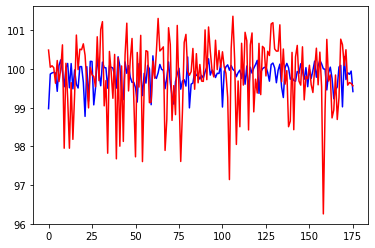

In [24]:
plt.plot(pred, color='blue')
plt.plot(y_test2, color='red')

In [27]:
p=future_x_inputs
p=np.reshape(p,(p.shape[0],p.shape[1],1))
t=model_lstm.predict(p)
t=np.exp(t)

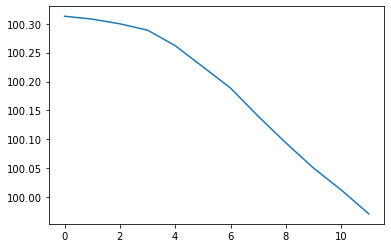

In [30]:
plt.plot(t)
#plt.plot(p)